In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

import sys
sys.path.append('resources')
import models

# Example

This extended example looks at [Mesquite](https://en.wikipedia.org/wiki/Mesquite) yields of leaves. It is basically a problem in biology/horticulture/agriculture.

In [4]:
mesquite = pd.read_csv( "resources/mesquite.tsv", sep="\t")

We don't have *specific* domain knowledge about this problem but we do have *general* domain knowledge. We'll see how that comes into play later in the example. For now, we know that we *should* have done EDA on this data long before we got to this point. In the interests of brevity, we will simply look at the contents of the data and the first rows:

In [5]:
mesquite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 8 columns):
obs              46 non-null int64
group            46 non-null object
diam1            46 non-null float64
diam2            46 non-null float64
total_height     46 non-null float64
canopy_height    46 non-null float64
density          46 non-null int64
weight           46 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 3.0+ KB


This is not a lot of data, really. There are only 46 observations.

In [6]:
mesquite.head()

,obs,group,diam1,diam2,total_height,canopy_height,density,weight
0,1,MCD,1.8,1.15,1.30,1.00,1,401.3
1,2,MCD,1.7,1.35,1.35,1.33,1,513.7
2,3,MCD,2.8,2.55,2.16,0.60,1,1179.2
3,4,MCD,1.3,0.85,1.80,1.20,1,308.0
4,5,MCD,3.3,1.90,1.55,1.05,1,855.2


We have several variables. The observation number (which is just an index and not a feature), the group, "diam1" and "diam2" (ostensibly to avoid trying to figure out which one was width and which was length), total_height of the tree, canopy_height, density, and the weight of the leaves. The weight is our target variable. Density is interesting. Let's see a bit more about it:

In [7]:
mesquite.density.describe()

count    46.000000
mean      1.673913
std       1.592403
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       9.000000
Name: density, dtype: float64

The most common value is 1 (by quite a long shot). It might be better to look at this as a discrete variable with a limited domain:

In [8]:
mesquite.density.value_counts(normalize=True)

1    0.717391
2    0.152174
3    0.065217
9    0.021739
7    0.021739
5    0.021739
Name: density, dtype: float64

71.7% of the observations of a density of 1 followed by 15.2% with a density of 2.

 Let's look at group as well:

In [9]:
mesquite.group.value_counts(normalize=True)

MCD    0.565217
ALS    0.434783
Name: group, dtype: float64

One of the libraries automatically converts the categorical variable into an encoding but we won't know which one is which so we should do it ourselves. Following our advice, we name the variable "mcd" for group=mcd or mcd=1 in which case als will be 0.

In [10]:
mesquite["mcd"] = mesquite.group.apply(lambda x: 1 if x == 'MCD' else 0)
mesquite.mcd.value_counts(normalize=True)

1    0.565217
0    0.434783
Name: mcd, dtype: float64

It's always good to make sure your transformations did what you expected. In any case, the two groups are almost exactly 50/50.

What do we think about the variables and their contributions to weight (of leaves)?

* **mcd** - we don't know what the groups are so it could be positive or negative.
* **diam1** - positive: more diameter is more leaves.
* **diam2** - positive: more diameter is more leaves.
* **total_height** - ??: a tall tree may just be tall with the canopy just higher off the ground.
* **canopy_height** - positive: more canopy, more leaves.
* **density** - positive: more leaves per unit, more leaves.

Let's fit a "all variables in" model:

In [11]:
model =  "weight ~ mcd + diam1 + diam2 + total_height + canopy_height + density"
result = models.bootstrap_linear_regression(model, data=mesquite)
print(models.describe_bootstrap_lr(result))

Model: weight ~ mcd + diam1 + diam2 + total_height + canopy_height + density
-------------  ---------  --------  --------  -------
                                    95% BCI
Coefficients              Mean      Lo        Hi
               $\beta_0$  -1091.89  -1614.68  -524.47
mcd            $\beta_1$  363.30    175.13    597.17
diam1          $\beta_2$  189.67    9.49      382.64
diam2          $\beta_3$  371.46    137.39    546.60
total_height   $\beta_4$  -101.73   -706.76   220.11
canopy_height  $\beta_5$  355.67    -61.22    1314.72
density        $\beta_6$  131.25    -18.98    300.57

Metrics        Mean       Lo        Hi
$\sigma$       268.96     93.37     307.93
$R^2$          0.85       0.78      0.95
-------------  ---------  --------  --------  -------


The $R^2$ is 85% which makes this a fairly good model in terms of explanation. We explain 85% of the variability in weight. We don't know the range of weight so we don't know if the $\sigma$ is any good. We would have normally found this out through EDA but let's look now:

In [12]:
mesquite.weight.describe()

count      46.00000
mean      559.66087
std       642.83481
min        60.20000
25%       219.62500
50%       361.85000
75%       688.72500
max      4052.00000
Name: weight, dtype: float64

We cut the error of our estimates from 642.8 to 268.96 with our model which is a pretty good increase in accuracy. Still, based on the actual application, it might not be enough. We might be interested in a good prediction of leaf weight or we might be interested in better explanatory for the model.

The coefficients are all over the place. Only diam2 is clearly positive. For the others, we have:

In [13]:
predictions = {"mcd": "+", "diam1": "+", "diam2": "+", "total_height": "+", "canopy_height": "+", "density": "+"}
models.evaluate_coefficient_predictions(predictions, result)

mcd P(>0)=1.000 (strong)
diam1 P(>0)=0.990 (strong)
diam2 P(>0)=0.990 (strong)
total_height P(>0)=0.370 (mixed)
canopy_height P(>0)=0.920 (strong)
density P(>0)=0.950 (strong)


First, all of the coefficients have the expected signs except total_height. We didn't even know what to expect with total_height. Second, many of the coefficients pass the bounds test except density. However, if we look at the posterior probabilities for all the coefficients, the evidence is strongly in favor of the observed signs. The only mixed result is for total_height.

Still, it seems like we have ample chances for problems here including multicollinearity. Trees don't just grow wide, staying 1 foot think (at least not usually). And total_height and canopy_height are surely correlated. Let's check a few of these:

In [14]:
print("diam1 v diam2 = {0:.2f}".format(stats.pearsonr(mesquite.diam1, mesquite.diam2)[0]))
print("total_height v canopy_height = {0:.2f}".format(stats.pearsonr(mesquite.total_height, mesquite.canopy_height)[0]))

diam1 v diam2 = 0.89
total_height v canopy_height = 0.84


Lot's of correlation on both accounts. We know that that will mess with our $\beta_i$ estimates. What about the residuals?

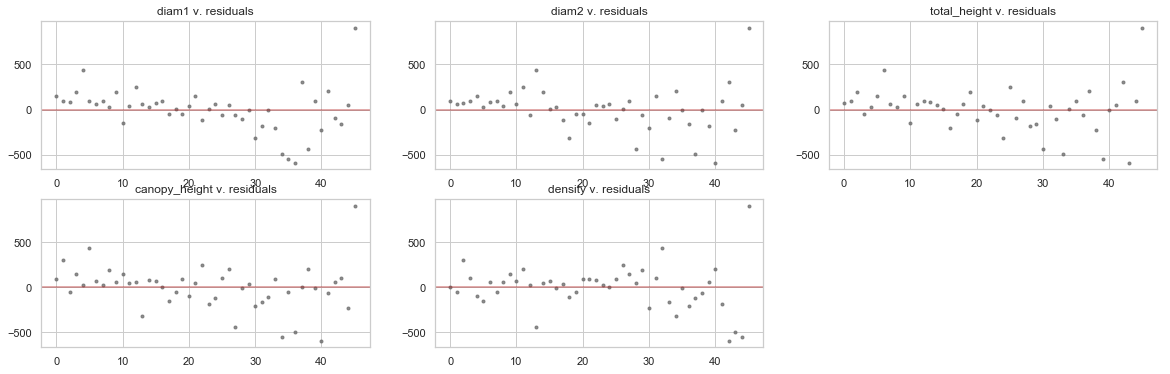

In [15]:
figure = plt.figure(figsize=(20,6))

variables = ["diam1", "diam2", "total_height", "canopy_height", "density"]

plots = len( variables)
rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)

    keyed_values = sorted( zip( mesquite[ variable].values, result[ "residuals"]), key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

We have two problems evident in all the residual plots. First, there's a pattern to the residuals. At low values, the errors are smaller and as the variable increases, the errors get larger. Second, we seem to be underestimating at low values for all the variables ($y - \hat{y} > 0$) and overestimating at high values ($y - \hat{y} < 0$).

This is where our *general* domain knowledge comes in. Is there really an *additive* relationship between diam(s), height, and weight? Aren't we really talking about *volume*? And if are talking about volume, isn't that a multiplicative model?

$y = diam1 \times diam2 \times canopy\_height$

We know from the transformation section that if we have a multiplicative model, we can transform it into an additive model by taking logs of all the variables:

In [16]:
def log( x):
    return np.log(float( x))

for column in ["diam1", "diam2", "total_height", "canopy_height", "weight", "density"]:
    mesquite[ "log_" + column] = mesquite[ column].apply( log)

In [17]:
mesquite[["log_diam1", "log_diam2", "log_total_height", "log_canopy_height", "log_weight", "log_density"]].describe()

,log_diam1,log_diam2,log_total_height,log_canopy_height,log_weight,log_density
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.664373,0.325520,0.340767,0.048187,5.919543,0.302183
std,0.393820,0.523814,0.337371,0.344195,0.913676,0.557538
min,-0.223144,-0.916291,-0.430783,-0.693147,4.097672,0.000000
25%,0.336472,0.000000,0.182322,-0.148229,5.391783,0.000000
50%,0.667501,0.421860,0.405465,0.095310,5.890144,0.000000
75%,0.906085,0.641854,0.530628,0.262364,6.534769,0.693147
max,1.648659,1.386294,1.098612,0.916291,8.306966,2.197225


Before estimating a new model, let's check the *adjusted* $R^2$:

In [18]:
models.adjusted_r_squared(result)

0.8154810264106127

Let's estimate the new model using just these new log() variables:

In [19]:
model =  "log_weight ~ log_diam1 + log_diam2 + log_total_height + log_canopy_height + log_density"
result = models.bootstrap_linear_regression(model, data=mesquite)
print(models.describe_bootstrap_lr(result))

Model: log_weight ~ log_diam1 + log_diam2 + log_total_height + log_canopy_height + log_density
-----------------  ---------  -----  -------  ----
                                     95% BCI
Coefficients                  Mean   Lo       Hi
                   $\beta_0$  4.97   4.59     5.33
log_diam1          $\beta_1$  0.73   0.11     1.26
log_diam2          $\beta_2$  0.79   0.28     1.22
log_total_height   $\beta_3$  0.70   -0.18    1.39
log_canopy_height  $\beta_4$  0.01   -0.65    0.81
log_density        $\beta_5$  -0.11  -0.45    0.06

Metrics            Mean       Lo     Hi
$\sigma$           0.40       0.29   0.46
$R^2$              0.83       0.73   0.91
-----------------  ---------  -----  -------  ----


How do we interpret the $\beta_i$s in such an model? They're *elasticities*: a 1% increase in $x_i$ leads to a $\beta_i$% increase in $y$.

The $R^2$ has dipped and the intervals have gotten sketchier. What about $\bar{R}^2$?

In [20]:
models.adjusted_r_squared(result)

0.7961538611828038

The adjusted $R^2$ fell as well. And what about our residuals?

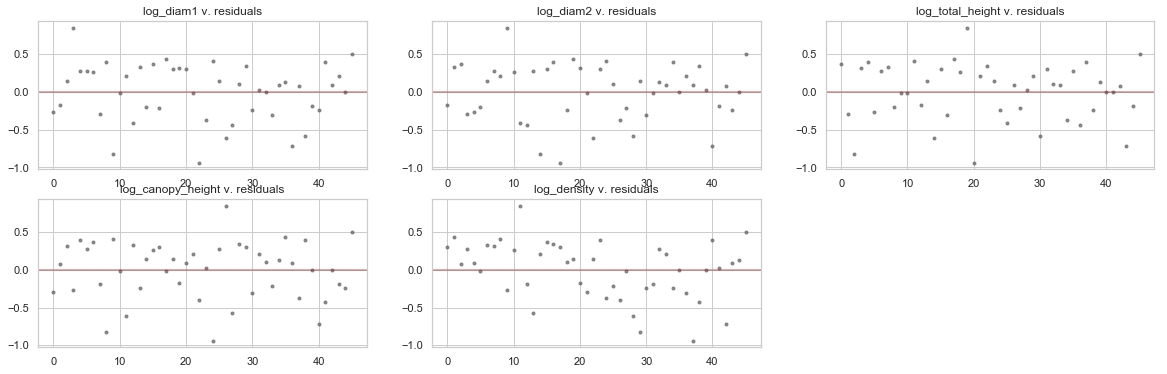

In [21]:
figure = plt.figure(figsize=(20,6))

variables = ["log_diam1", "log_diam2", "log_total_height", "log_canopy_height", "log_density"]

plots = len( variables)
rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)

    keyed_values = sorted( zip( mesquite[ variable].values, result[ "residuals"]), key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

*Most* of the residuals are fixed; density still looks a little heteroskedastic.

Perhaps there's still just too much multicollinearity. Volume is the product of all the dimensions and for an arbitrary three dimensional shape, one of those might vary significantly but probably not for trees. Maybe we should just use a *volume* feature. In "log space", log_volume is the *sum* of the three dimensions:

In [22]:
mesquite[ "log_canopy_volume"] = mesquite[ "log_diam1"] + mesquite[ "log_diam2"] + mesquite[ "log_canopy_height"]

In [23]:
model =  "log_weight ~ log_canopy_volume"
result = models.bootstrap_linear_regression(model, data=mesquite)
print(models.describe_bootstrap_lr(result))

Model: log_weight ~ log_canopy_volume
-----------------  ---------  ----  -------  ----
                                    95% BCI
Coefficients                  Mean  Lo       Hi
                   $\beta_0$  5.17  5.01     5.30
log_canopy_volume  $\beta_1$  0.72  0.64     0.81

Metrics            Mean       Lo    Hi
$\sigma$           0.41       0.33  0.49
$R^2$              0.80       0.66  0.88
-----------------  ---------  ----  -------  ----


Almost all of the variation in weight comes from volume. Still, our $R^2$ isn't as high as it was (which may be because of the number of variables used in the different models). What about adjusted $R^2$?

In [24]:
models.adjusted_r_squared(result)

0.7848634245562538

It's lower than what we've seen but this is just *one* variable in the model. Are we missing anything else? There are two possible additional features:

$area = diam1 \times diam2$

$shape = diam1 \div diam2$

With our log representations, these are addition and subtraction:

In [25]:
mesquite[ "log_canopy_area"] = mesquite[ "log_diam1"] + mesquite[ "log_diam2"]
mesquite[ "log_canopy_shape"] = mesquite[ "log_diam1"] - mesquite[ "log_diam2"]

We expect both of these to be positively related to weight:

In [26]:
model =  "log_weight ~ log_canopy_volume + log_canopy_area + log_canopy_shape"
result = models.bootstrap_linear_regression(model, data=mesquite)
print(models.describe_bootstrap_lr(result))

Model: log_weight ~ log_canopy_volume + log_canopy_area + log_canopy_shape
-----------------  ---------  -----  -------  ----
                                     95% BCI
Coefficients                  Mean   Lo       Hi
                   $\beta_0$  5.12   4.83     5.49
log_canopy_volume  $\beta_1$  0.40   -0.04    1.00
log_canopy_area    $\beta_2$  0.42   -0.36    1.00
log_canopy_shape   $\beta_3$  -0.08  -0.55    0.34

Metrics            Mean       Lo     Hi
$\sigma$           0.41       0.31   0.49
$R^2$              0.81       0.68   0.90
-----------------  ---------  -----  -------  ----


In [27]:
models.adjusted_r_squared(result)

0.7865195478356122

Still not as good as the original model,

In [28]:
predictions = {"log_canopy_volume": "+", "log_canopy_area": "+", "log_canopy_shape": "+"}
models.evaluate_coefficient_predictions(predictions, result)

log_canopy_volume P(>0)=0.960 (strong)
log_canopy_area P(>0)=0.790 (strong)
log_canopy_shape P(>0)=0.370 (mixed)


and the evidence for our new features is mixed in one case but strong in the others. However, the model makes *sense* so let's add in the other features:

In [29]:
model =  "log_weight ~ log_canopy_volume + log_canopy_area + log_canopy_shape + mcd + log_total_height + log_density"
result = models.bootstrap_linear_regression(model, data=mesquite)
print(models.describe_bootstrap_lr(result))

Model: log_weight ~ log_canopy_volume + log_canopy_area + log_canopy_shape + mcd + log_total_height + log_density
-----------------  ---------  -----  -------  -----
                                     95% BCI
Coefficients                  Mean   Lo       Hi
                   $\beta_0$  4.77   4.38     5.08
log_canopy_volume  $\beta_1$  0.37   0.15     1.41
log_canopy_area    $\beta_2$  0.40   -0.68    0.61
log_canopy_shape   $\beta_3$  -0.38  -0.89    -0.05
mcd                $\beta_4$  0.58   0.46     0.87
log_total_height   $\beta_5$  0.39   -0.64    0.85
log_density        $\beta_6$  0.11   -0.09    0.29

Metrics            Mean       Lo     Hi
$\sigma$           0.33       0.21   0.35
$R^2$              0.89       0.85   0.96
-----------------  ---------  -----  -------  -----


In [30]:
models.adjusted_r_squared(result)

0.8629155301645439

This is our best result so far judging by the adjusted $R^2$. The signs on almost all of the coefficients are what we expect. What about the evidence?

In [31]:
predictions = {"log_canopy_volume": "+", "log_canopy_area": "+", "log_canopy_shape": "+", "mcd": "+",
               "log_total_height": "+", "log_density": "+"}
models.evaluate_coefficient_predictions(predictions, result)

log_canopy_volume P(>0)=0.990 (strong)
log_canopy_area P(>0)=0.700 (strong)
log_canopy_shape P(>0)=0.020 (weak)
mcd P(>0)=1.000 (strong)
log_total_height P(>0)=0.750 (strong)
log_density P(>0)=0.900 (strong)


The evidence for all the coefficients is strong except log_canopy_shape. However, the evidence is strong for log_canopy_shape being negative *is* strong so we will need to revisit our theory about what this is measuring.

Finally, we need to look at the residuals:

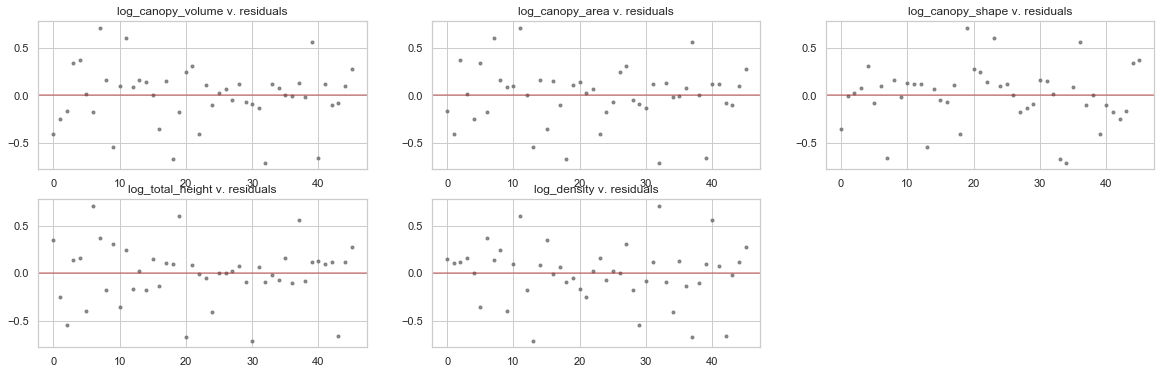

In [32]:
figure = plt.figure(figsize=(20,6))

variables = ["log_canopy_volume", "log_canopy_area", "log_canopy_shape", "log_total_height", "log_density"]

plots = len( variables)
rows = (plots // 3) + 1

for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)

    keyed_values = sorted( zip( mesquite[ variable].values, result[ "residuals"]), key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

plt.show()
plt.close()

Our residuals seem to be pretty good.

When you are building a regression based on domain knowledge for the purpose of explanation (you are interested in the coefficient values) or prediction (you're just interested in the $\sigma$ and $R^2$), this is the basic approach you take. If this is the ultimate goal, this will inform your EDA a bit. You will start to look for broad patterns in variables:

1. Is this variable approximately Normally distributed?
2. If this variable doesn't look Normally distributed, are there transformations I can apply to make it normally distributed?
3. Is there domain knowledge that suggests there might be increasing or decreasing returns from this variable? Should I then look at squared or square-root transformations of the variable?